In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd

[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1982","2010"]
file_path = os.path.expandvars('$HOME/data/oisst/sst.mon.mean.nc')
ds = xr.open_dataset(file_path)
sst = ds['sst'].isel(time=0)

file_path = os.path.expandvars('$WORK/data/CMIP6/AWI-CM-1-1-HR/regrid/tos_his_1981-2010_r360_180.nc')
ds = xr.open_dataset(file_path)
lat = ds['lat'].sel(lat=slice(ymin,ymax)).values
lon = ds['lon'].sel(lon=slice(xmin,xmax)).values
time = ds['time'].values  
time_dates = pd.to_datetime(time)  # 转换为 datetime 对象
time_years = time_dates.year + (time_dates.month - 1) / 12

sst_interp = sst.interp(lat=lat, lon=lon)

coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst_interp[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  


In [3]:
# cmip6 tos
root_dir = '/gxfs_work/geomar/smomw639/data/CMIP6/'

model = []
tos = []
# Get the list of subdirectories and sort them
subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
subdirs.sort(key=lambda d: d.lower())  # Sort the subdirectories in alphabetical order

# Walk through the sorted list of subdirectories
for subdir in subdirs:
    target_file = 'regrid/tos_his_1981-2010_r360_180.nc'
    file_path = os.path.join(subdir, target_file)
    if os.path.isfile(file_path):
        ds = xr.open_dataset(file_path)
        tos.append(ds['tos'].sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax),time=slice(tmin,tmax)).values)
        model.append(os.path.basename(subdir))
ds = xr.open_dataset(os.path.expandvars('$HOME/data/oisst/sst.mon.mean.nc'))
tos.append(ds['sst'].sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax),time=slice(tmin,tmax)).interp(lat=lat, lon=lon).values)
model.append('OISST')
sst=np.array(tos)

n = 2
sstc = np.empty((sst.shape[0],sst.shape[1],len(coast['lat']), n))
ssto = np.empty((sst.shape[0],sst.shape[1],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))


for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:,:, point_idx, :] = sst[:,:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    ssto[:,:, point_idx, :] = sst[:,:, lat_idx, int(lon_idx-n-n) : int(lon_idx-n)]  # offshore band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc-ssto
sstum=np.mean(sstu.reshape(sstu.shape[0],int(sstu.shape[1]/12),12,sstu.shape[2],sstu.shape[3]), axis=1)


/tmp/ipykernel_3167248/304632674.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(t)}°N' for t in y_ticks])


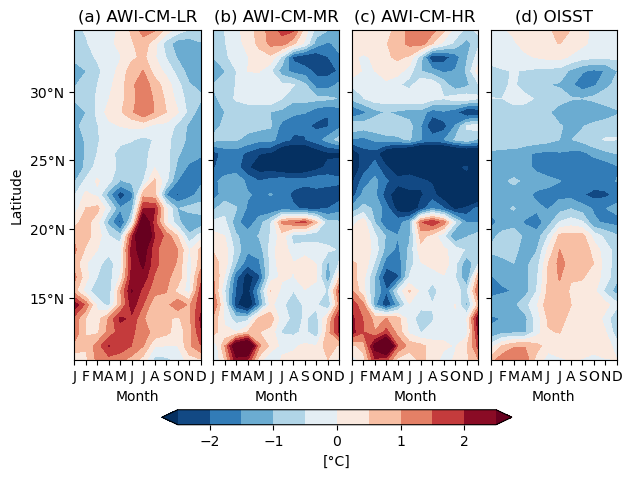

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(7, 5))

# 🔹 reserve bottom space BEFORE plotting
fig.subplots_adjust(bottom=0.22, wspace=0.1)

labels = ['(a)', '(b)', '(c)', '(d)']
models = ['AWI-CM-LR', 'AWI-CM-MR', 'AWI-CM-HR', 'OISST']
titles = [f"{lab} {mod}" for lab, mod in zip(labels, models)]

datasets = [
    np.squeeze(sstum[1,:,:,:]),
    np.squeeze(sstum[2,:,:,:]),
    np.squeeze(sstum[0,:,:,:]),
    np.squeeze(sstum[3,:,:,:])
]

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
cl = 2.5
levels = np.linspace(-cl, cl, 11)

for i, (data, title, ax) in enumerate(zip(datasets, titles, axes)):
    hov_data = np.nanmean(data, axis=-1)

    cf = ax.contourf(
        np.arange(12), lat, hov_data.T,
        levels=levels, extend='both', cmap='RdBu_r'
    )

    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(month_labels)

    if i == 0:
        ax.set_ylabel('Latitude')
        y_ticks = ax.get_yticks()
        ax.set_yticklabels([f'{int(t)}°N' for t in y_ticks])
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])

# 🔹 colorbar axis in reserved space
cax = fig.add_axes([0.25, 0.09, 0.5, 0.03])
cbar = fig.colorbar(cf, cax=cax, orientation='horizontal')
cbar.set_label('[°C]')
plt.savefig("figA2.png", dpi=300, bbox_inches='tight')                    

plt.show()


In [15]:
# wind ekman transport and pumping


ds = xr.open_dataset('/gxfs_work/geomar/smomw639/data/CMIP6/AWI-CM-1-1-MR/regrid/vas_his_1981-2010_r360_180.nc')
v=ds['vas'].sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax),time=slice(tmin,tmax)).values
ds = xr.open_dataset('/gxfs_work/geomar/smomw639/data/CMIP6/AWI-CM-1-1-MR/regrid/uas_his_1981-2010_r360_180.nc')
u=ds['uas'].sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax),time=slice(tmin,tmax)).values

n = 2
uc = np.empty((u.shape[0],len(coast['lat']), n))
vc = np.empty((v.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = u[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = v[:, lat_idx, int(lon_idx-n) : int(lon_idx)]

uc[np.abs(uc) > 100] = np.nan
vc[np.abs(vc) > 100] = np.nan

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
wind_alongshore = uc * u_alongshore + vc * v_alongshore

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, latc, lonc)  # Shape: (100, 8)

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

f = 2 * omega * np.sin(latc* np.pi / 180)

# Calculate magnitude of horizontal velocity
windspeed = np.sqrt(uc**2 + vc**2)

# Ekman transport calculation
etransport = -rhoa * cd * windspeed * wind_alongshore / (rho * f * distances) *86400  # m/d

dy = 111000*(lon[1]-lon[0])  # 1 degree latitude ~ 111 km
epumping = rhoa * cd * windspeed * (np.gradient(vc, dy, axis=2)-np.gradient(uc, dy, axis=1)) / (rho * f)
etransportm=np.mean(etransport.reshape(int(epumping.shape[0]/12),12,epumping.shape[1],epumping.shape[2]), axis=0)


/tmp/ipykernel_464244/1934010345.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(lat)}°' for lat in y_ticks])


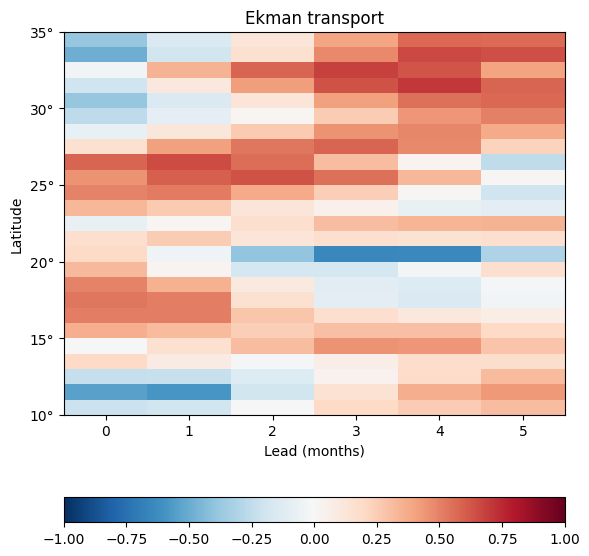

In [24]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

target=-np.squeeze(sstu[2,:,:,:])
max_lag = 5  

def calculate_seasonal_lagged_correlation(variable1, variable2, max_lag):
    lagged_corr = np.zeros((max_lag + 1, variable2.shape[1]))  # Store correlation for each lag and latitude

    for lag in range(0, max_lag + 1):  # We want lags from -max_lag to max_lag
        for lat in range(variable2.shape[1]):
            # Circularly shift variable2 along the time axis using np.roll()
            var1_shifted = np.roll(variable1[:, lat, :], shift=-lag, axis=0)  # Circular shift
            
            # Average across longitudes (axis=-1)
            var1_flat = np.mean(var1_shifted, axis=-1)  # Keep variable1 unchanged
            var2_flat = np.mean(variable2[:, lat, :], axis=-1)  # Shifted variable2
            
            # Calculate the Pearson correlation coefficient for this latitude and lag
            corr, _ = pearsonr(var1_flat, var2_flat)
            lagged_corr[lag, lat] = corr

    return lagged_corr

# Calculate lagged correlations for each variable
lagged_corr_etransport = calculate_seasonal_lagged_correlation(target, etransport, max_lag)

# Define the lags and latitude axes for the plot
lags = np.arange(max_lag + 1)  # From -5 to 5 months
latitudes = latc[:, 0]  # Assuming latc is latitude data

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
titles = ['Ekman transport']
datasets = [lagged_corr_etransport]

# Plot for each dataset
for i, (data, title) in enumerate(zip(datasets, titles)):
    c = ax.pcolormesh(lags, latitudes, data.T, shading='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(title)
    ax.set_xlabel('Lead (months)')
    ax.set_ylabel('Latitude')
    y_ticks = ax.get_yticks()
    ax.set_yticklabels([f'{int(lat)}°' for lat in y_ticks])
    fig.colorbar(c, ax=ax, orientation='horizontal')

plt.tight_layout()
plt.show()


In [7]:
sstu.shape

(4, 348, 25, 2)